## Gene summary w/ % essential and paralogy
**Inputs:** 
* Gene scores - the results of running CERES
* Paralog genes
* Calculated cutoff score (-0.47)

**Outputs:**
* Binary calls: for each gene in each cell lines, whether the gene is essential in that cell line (0/1)
* Gene summary: % of cell lines each gene is essential in, using <= -0.47 (previously calculated cutoff scores) as essential + gene paralogy info

In [2]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import sys
sys.path.append('../2_data_analysis')

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_gene_scores = get_local_data_path(['processed','depmap19Q1'], 'gene_scores_11_07_19.csv')
file_paralogs = get_local_data_path(['processed','ensembl93'], 'paralog_summary.csv')
cutoff_score = -0.47

# Output
file_binary_scores = get_local_data_path(['processed','depmap19Q1'], 'binary_scores_11_07_19.csv')
file_gene_summary = get_local_data_path(['processed','results'],'gene_summary_'+str(abs(cutoff_score))+'.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gene_scores = pd.read_csv(file_gene_scores, index_col=0).set_index('cell_line')
print("Num cell lines: " + str(gene_scores.shape[0]))
print("Num genes: " + str(gene_scores.shape[1]))
display(gene_scores[:1])

Num cell lines: 558
Num genes: 16540


,8036,55967,55153,25940,23224,116071,114803,1967,23014,29957,...,128344,55249,84304,5869,57818,5273,84952,11046,90594,400
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-000601,-0.117838,-0.083374,-0.75716,-0.07252,-0.012776,-0.119112,0.053607,-1.092377,-0.234541,-0.018627,...,-0.18303,-0.096821,-0.092369,0.004617,0.010656,-0.008256,0.003173,-0.062839,-0.016976,-0.154559


In [7]:
# Binarize gene scores based on given cutoff score
# fn applymap() = apply a function to a Dataframe elementwise, i.e. to each cell
binarized_scores = gene_scores.applymap(lambda x: int(x <= cutoff_score))
# binarized_scores.to_csv(file_binary_scores)
display(binarized_scores[:1])
print('Median num essential genes per cell line: %d = %.3f%%' % (binarized_scores.sum(axis=1).median(), 
      binarized_scores.sum(axis=1).median()/binarized_scores.shape[1] *100))

,8036,55967,55153,25940,23224,116071,114803,1967,23014,29957,...,128344,55249,84304,5869,57818,5273,84952,11046,90594,400
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-000601,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Median num essential genes per cell line: 1678 = 10.145%


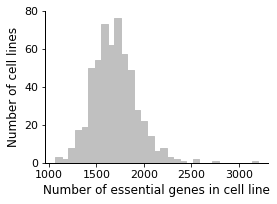

In [5]:
f, ax = plt.subplots(1, 1, figsize=(4,2.8))
sns.distplot(binarized_scores.sum(axis=1), kde=False, ax=ax, color='silver', hist_kws={"alpha": 1, "rwidth":1, 'edgecolor':'silver'})
ax.set_xlabel('Number of essential genes in cell line')
ax.set_ylabel('Number of cell lines')
ax.set_ylim([0, 80])
#plt.savefig('../figures/fig_S1C.svg', bbox_inches='tight', dpi=300)

In [8]:
# Create new data frame with % of cell lines each gene is essential in + essentiality label
gene_essentiality = pd.DataFrame(binarized_scores.apply(lambda x: sum(x)/len(x)), columns=['essential_percent'])
gene_essentiality.index.names = ['entrez_id']
gene_essentiality = gene_essentiality.reset_index()

# Essentiality categories: Never (0%), Sometimes and Broadly (>90%)
get_cat_label = lambda x: 'Never' if x == 0 else ('Broadly' if x > 0.9 else 'Sometimes')
gene_essentiality = gene_essentiality.assign(category = gene_essentiality.essential_percent.apply(get_cat_label))
assert(gene_essentiality[gene_essentiality.category=='Broadly'].shape[0] == 
       gene_essentiality[gene_essentiality.essential_percent>0.9].shape[0])

print('%% never essential: %.4f' % (sum(gene_essentiality.category=='Never')/gene_essentiality.shape[0]))
print('%% sometimes essential: %.4f' % (sum(gene_essentiality.category=='Sometimes')/gene_essentiality.shape[0]))
print('%% broadly essential: %.2f' % (sum(gene_essentiality.category=='Broadly')/gene_essentiality.shape[0]))
gene_essentiality[:1]

% never essential: 0.4755
% sometimes essential: 0.4632
% broadly essential: 0.06


,entrez_id,essential_percent,category
0,8036,0.069892,Sometimes


In [12]:
# Add paralogy info
# Note: assumes all screened genes that aren't in paralog summary are singletons
paralog_data = pd.read_csv(file_paralogs, index_col=0)
gene_summary = pd.merge(gene_essentiality.astype({'entrez_id':'int'}), paralog_data, on='entrez_id', how='left')
print('Paralogs in merged: %d = %.3f%%' % (gene_summary[gene_summary.num_paralogs > 0].shape[0], 
      gene_summary[gene_summary.num_paralogs > 0].shape[0]/gene_summary.shape[0]*100))
print('WGDs: %.3f%%' % (gene_summary[gene_summary.WGD=='WGD'].shape[0]/gene_summary[gene_summary.num_paralogs>0].shape[0]*100))

# Clean-up NaNs for singletons in merged data set
gene_summary = gene_summary.fillna({'percent_matched_in_paralog':0, 'num_paralogs':0, 'WGD':'Singleton'}).astype({'num_paralogs':'int'})
assert(gene_summary[gene_summary.num_paralogs==0].shape[0] == gene_summary[gene_summary.WGD=='Singleton'].shape[0])

print('N genes:', gene_summary.shape[0])
gene_summary[:1]

Paralogs in merged: 10130 = 61.245%
WGDs: 64.442%
N genes: 16540


,entrez_id,essential_percent,category,ensembl_id,symbol,percent_matched_in_paralog,num_paralogs,WGD
0,8036,0.069892,Sometimes,ENSG00000108061,SHOC2,0.254296,2,SSD


In [13]:
# Export gene summary
gene_summary.to_csv(file_gene_summary, index=0)

### Export tables to include with the paper

In [14]:
gene_scores.to_csv(get_local_data_path(['supplemental_files'], 'Table_S1.csv'))
binarized_scores.to_csv(get_local_data_path(['supplemental_files'], 'Table_S2.csv'))
table_s3 = gene_summary.rename(columns={'category':'essential_category', 
                                        'percent_matched_in_paralog':'percent_matched_in_closest_paralog',
                                        'WGD':'duplication_mode'})
table_s3 = table_s3[['symbol', 'entrez_id', 'ensembl_id', 'essential_category', 'essential_percent', 
                     'num_paralogs', 'percent_matched_in_closest_paralog', 'duplication_mode']]
table_s3 = table_s3.set_index('symbol').sort_index()
display(table_s3[:2])
table_s3.to_csv(get_local_data_path(['supplemental_files'], 'Table_S3.csv'))

,entrez_id,ensembl_id,essential_category,essential_percent,num_paralogs,percent_matched_in_closest_paralog,duplication_mode
symbol,,,,,,,
A1CF,29974,ENSG00000148584,Never,0.0,4,0.468439,WGD
A2M,2,ENSG00000175899,Never,0.0,5,0.725237,WGD
